# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

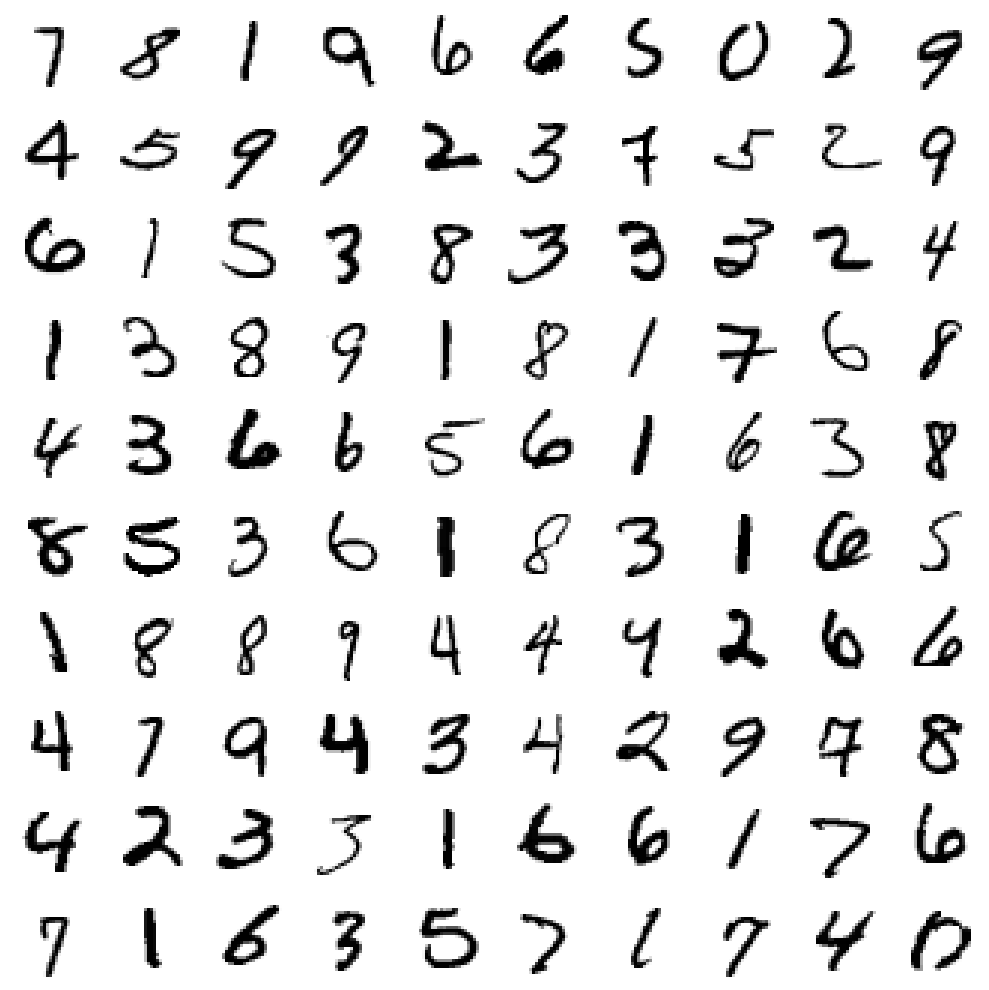

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

from Code_practicals_4 import *

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

params_model1 = model.count_params()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

Compile and train the network (note that this could take a while).

In [3]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 29s 61ms/step - loss: 0.2468 - accuracy: 0.9244 - val_loss: 0.0586 - val_accuracy: 0.9812
Epoch 2/12
469/469 [==============================] - 29s 61ms/step - loss: 0.0870 - accuracy: 0.9741 - val_loss: 0.0391 - val_accuracy: 0.9869
Epoch 3/12
469/469 [==============================] - 38s 81ms/step - loss: 0.0642 - accuracy: 0.9802 - val_loss: 0.0350 - val_accuracy: 0.9883
Epoch 4/12
469/469 [==============================] - 44s 94ms/step - loss: 0.0529 - accuracy: 0.9837 - val_loss: 0.0284 - val_accuracy: 0.9913
Epoch 5/12
469/469 [==============================] - 51s 109ms/step - loss: 0.0440 - accuracy: 0.9862 - val_loss: 0.0303 - val_accuracy: 0.9906
Epoch 6/12
469/469 [==============================] - 52s 110ms/step - loss: 0.0390 - accuracy: 0.9880 - val_loss: 0.0315 - val_accuracy: 0.9909
Epoch 7/12
469/469 [==============================] - 54s 115ms/step - loss: 0.0347 - accuracy: 0.9893 - val_loss: 0.0250 - val_accura

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [4]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02843744494020939
Test accuracy: 0.9919999837875366


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. The images corresponding to the DRIVE test set can be found [here](https://www.dropbox.com/s/zk51wgupimw7jd9/DRIVE.zip?dl=0).

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


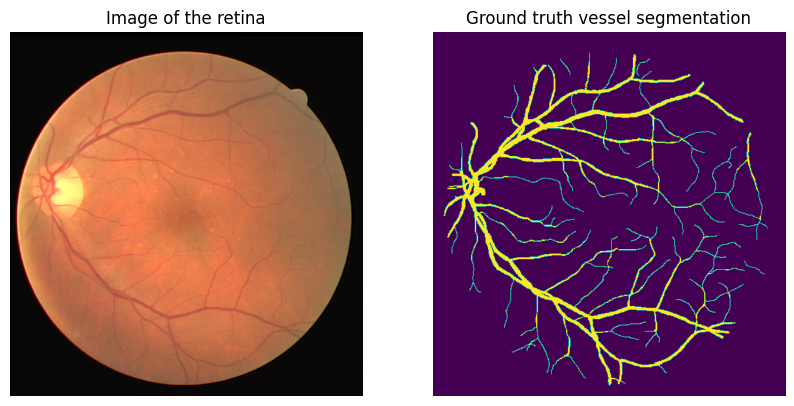

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = 'data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


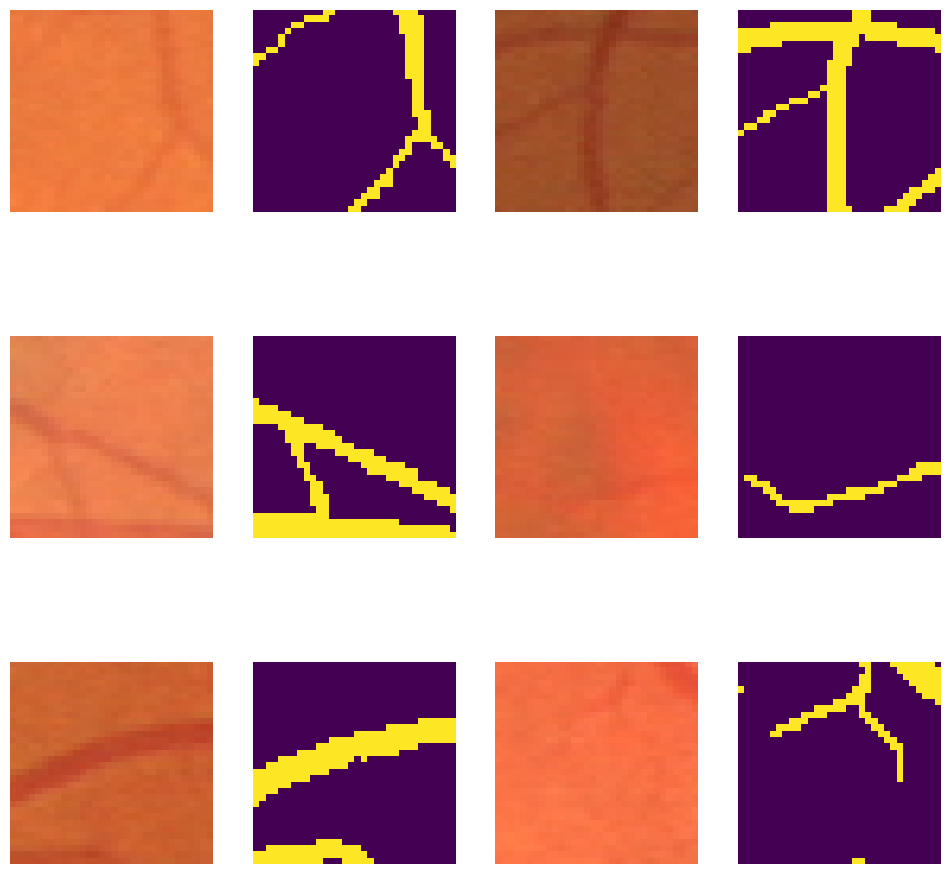

In [6]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [7]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [8]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, Y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(Y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 25
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit(datagenerator(X_train, Y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/25
50/50 [==============================] - 33s 592ms/step - loss: 0.5388 - accuracy: 0.8086 - val_loss: 1.1667 - val_accuracy: 0.4622
Epoch 2/25
50/50 [==============================] - 23s 451ms/step - loss: 0.2983 - accuracy: 0.9497 - val_loss: 0.3899 - val_accuracy: 0.9211
Epoch 3/25
50/50 [==============================] - 26s 530ms/step - loss: 0.2245 - accuracy: 0.9555 - val_loss: 0.2967 - val_accuracy: 0.9211
Epoch 4/25
50/50 [==============================] - 23s 468ms/step - loss: 0.2048 - accuracy: 0.9505 - val_loss: 4.7312 - val_accuracy: 0.4051
Epoch 5/25
50/50 [==============================] - 24s 475ms/step - loss: 0.1632 - accuracy: 0.9575 - val_loss: 0.3204 - val_accuracy: 0.9211
Epoch 6/25
50/50 [==============================] - 24s 482ms/step - loss: 0.1478 - accuracy: 0.9569 - val_loss: 0.2804 - val_accuracy: 0.9213
Epoch 7/25
50/50 [==============================] - 25s 496ms/step - loss: 0.1338 - accuracy: 0.9595 - val_l

### Visualizing the segmentation results

1/1 [==============================] - 1s 1s/step


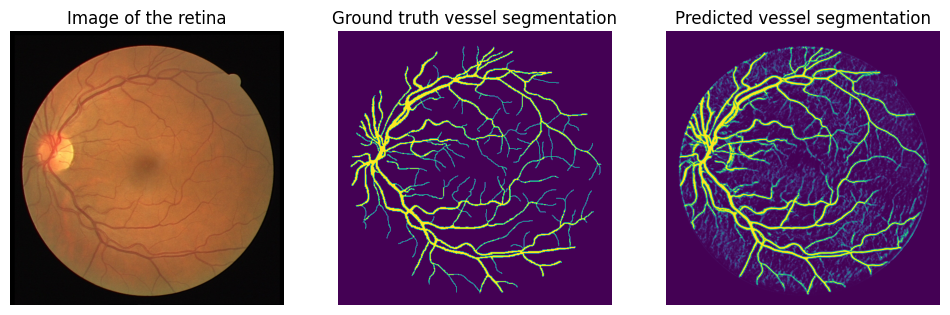

In [9]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, Y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters.

 What do these parameters correspond to? 
 The input contains of a 28-by-28 sized image. In the first layer a convolutional filter is applied with size 3-by-3 and filter depth 32. Using the general equation to obtain the number of parameters results in ((3*3*1+1)*32) = 320. So, these 320 parameters correspond to the weights in the kernel. 

 The flatten layer right before the fully connected layer contains 9216 nodes. The next layer contains 128 nodes. This results in 9216*128+128 = 1179776 parameters including 128 parameters that represent the bias of the model. 

 

<font color='#775a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

For the convolutional layer the general expression for the number of parameters equals $$ \text{number of params} = ((m \times n \times d + 1)\times k) $$
$$m = \text{Shape of width of the filter}$$
$$n = \text{Shape of height of the filter} $$
$$d = \text{Number of filters in previous layer}$$
$$k = \text{Number of filters}$$

For the fully connected layer the general expression for the number of parameters equals $$ \text{Number of params} = (n+1)*m$$
$$ n = \text{Shape of width of the filter} $$
$$ m = \text{Shape of height of the filter} $$

Where the + 1 terms represents the bias. 

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

In [10]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(Conv2D(24, (6, 6), activation='relu'))
model2.add(Conv2D(21, (1, 1), activation='relu'))
model2.add(Conv2D(10, (1, 1), activation='softmax'))
model2.add(Reshape([10]))

params_model2 = model2.count_params()

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 10, 10, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 conv2d_24 (Conv2D)          (None, 6, 6, 256)         590080    
                                                      

In [11]:
print('Nr of params model 1: ', params_model1)
print('Nr of params model 2: ', params_model2)

Nr of params model 1:  1199882
Nr of params model 2:  1199873


In [12]:
model2.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model2.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 193s 409ms/step - loss: 0.1987 - accuracy: 0.9392 - val_loss: 0.0669 - val_accuracy: 0.9796
Epoch 2/12
469/469 [==============================] - 186s 397ms/step - loss: 0.0497 - accuracy: 0.9853 - val_loss: 0.0310 - val_accuracy: 0.9893
Epoch 3/12
469/469 [==============================] - 189s 403ms/step - loss: 0.0317 - accuracy: 0.9901 - val_loss: 0.0266 - val_accuracy: 0.9918
Epoch 4/12
469/469 [==============================] - 192s 408ms/step - loss: 0.0251 - accuracy: 0.9925 - val_loss: 0.0381 - val_accuracy: 0.9881
Epoch 5/12
469/469 [==============================] - 192s 410ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0395 - val_accuracy: 0.9885
Epoch 6/12
469/469 [==============================] - 193s 412ms/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.0311 - val_accuracy: 0.9900
Epoch 7/12
469/469 [==============================] - 195s 415ms/step - loss: 0.0152 - accuracy: 0.9952 - val_loss: 0.0241 -

In [13]:
score2 = model2.evaluate(x_test, y_test, verbose=0)

print('Test loss model 1:', score[0])
print('Test loss model 2:', score2[0])
print('Test accuracy model 1:', score[1])
print('Test accuracy model 2:', score2[1])

Test loss model 1: 0.02843744494020939
Test loss model 2: 0.029709048569202423
Test accuracy model 1: 0.9919999837875366
Test accuracy model 2: 0.9918000102043152


A second model architecture has been set up without the use of dense layers but only with convolutional layers. This model uses only 9 parameters less than the original model. 
When tested on the same data, it can be observed that the test loss and accuracy of the fully-convolutional model very closely approach the values of the original model.

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

Answer: The encoder part of the UNet architecture is for capturing the context of the input image, while the decoder is for recovering the spatial resolution of the input image and reconstructing the segmentation map. The skip connections directly connect the layers of the encoder and decoder paths. The purpose of the skip connections is to bypass the bottleneck part of the model, which is the transition between the encoder and decoder. Another feature of the skip connecions is giving detailed information about the input image to the decoder part of the architeture.

The encoder path reduces the spatial dimensions, so fine-grained details could be lost from the input image. When reconstructing in the decoder part, those details cannot be implemented again without using the skip connections. The skip connections provide fine-grained details to the decoder, making the reconstruction more detailed. In conclusion, without the skip connections, UNet can still make predictions, but some fine-grained details could be lost. Additionally, the skip connections are important for backpropagation during model training. With skip connections, the gradient flow is improved in the encoder part of the network.


## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

Answer: Data augmentation results in a larger training dataset with more variation. This allows the model to learn more varied training data and it prevents overfitting on noise in the original dataset without data augmentation. It is not logical to use data augmentation on the testing set because this is used to get a model evaluation. With the testing set, you aim to discover the accuracy of the model on independent samples. Adding extra variations to the testing data with data augmentation will most likely disrupt the evaluation process and give you a scewed look on the performance of the model.

----------------------------------------------------------

Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Explanation: the functions `datagenerator` and `extract_patches` were adjusted to facilitate the data augmentation directly on the image patches. In the function `extract_patches`, the function `data_augmentation` is called if the patches are supposed to be augmented. The function `data_augmentation` is located in the file `Code_practicals_4.py`.

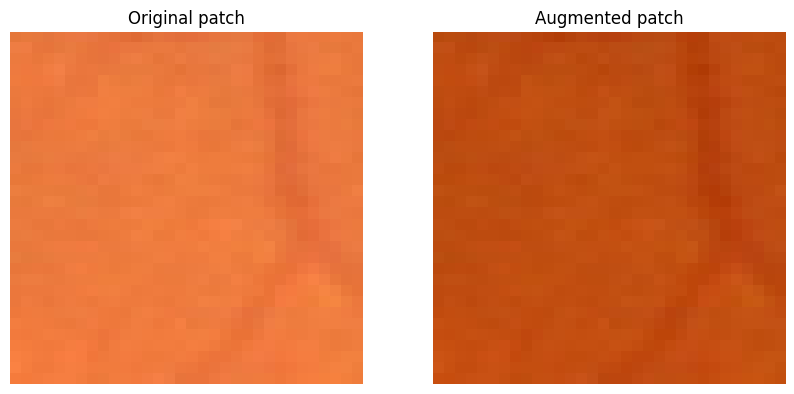

In [19]:
# Plotting an example of an augmented brightness patch
patches_brightness, _ = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7, augment=True, brightness=True, bspline=False)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(patches[0])
ax[1].imshow(patches_brightness[0])
ax[0].set_title("Original patch")
ax[1].set_title("Augmented patch")
[axis.axis("off") for axis in ax];

In [21]:
# Initialize model
model_brightness = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# Compile the model
model_brightness.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping_augmented = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# The data augmentation is directly applied via the data generator
history_augmented = model_brightness.fit(datagenerator(X_train, Y_train, patch_size, patches_per_im, batch_size, augment=True, brightness=True, bspline=False),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
                              callbacks=[early_stopping_augmented])

Epoch 1/25
50/50 [==============================] - 31s 559ms/step - loss: 0.5472 - accuracy: 0.8007 - val_loss: 0.7908 - val_accuracy: 0.3416
Epoch 2/25
50/50 [==============================] - 24s 469ms/step - loss: 0.3288 - accuracy: 0.9418 - val_loss: 0.3342 - val_accuracy: 0.9211
Epoch 3/25
50/50 [==============================] - 25s 489ms/step - loss: 0.2624 - accuracy: 0.9448 - val_loss: 0.7252 - val_accuracy: 0.4483
Epoch 4/25
50/50 [==============================] - 23s 461ms/step - loss: 0.1987 - accuracy: 0.9530 - val_loss: 0.2835 - val_accuracy: 0.9211
Epoch 5/25
50/50 [==============================] - 24s 481ms/step - loss: 0.1639 - accuracy: 0.9556 - val_loss: 0.2938 - val_accuracy: 0.9211
Epoch 6/25
50/50 [==============================] - 24s 476ms/step - loss: 0.1528 - accuracy: 0.9555 - val_loss: 0.2994 - val_accuracy: 0.9206
Epoch 7/25
50/50 [==============================] - 25s 503ms/step - loss: 0.1290 - accuracy: 0.9599 - val_loss: 0.2817 - val_accuracy: 0.9196

In [22]:
score_baseline = model.evaluate(val_images, val_segmentations, verbose=1)
score_brightness = model_brightness.evaluate(val_images, val_segmentations, verbose=1)

print('Test loss baseline model:', score_baseline[0])
print('Test loss augmented brightness model:', score_brightness[0])

print('Test accuracy baseline model:', score_baseline[1])
print('Test accuracy augmented brightness model:', score_brightness[1])

1/1 [==============================] - 3s 3s/step - loss: 0.1680 - accuracy: 0.9432
Test loss baseline model: 0.3285822868347168
Test loss augmented brightness model: 0.16795265674591064
Test accuracy baseline model: 0.8707030415534973
Test accuracy augmented brightness model: 0.943219006061554


1/1 [==============================] - 1s 823ms/step


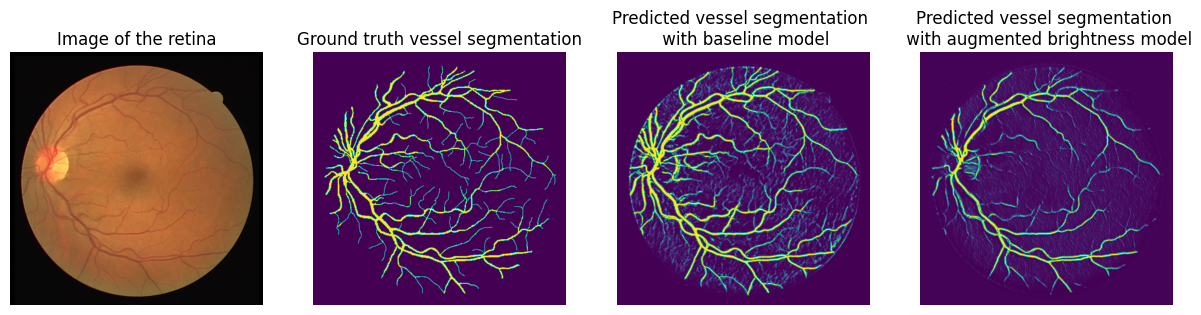

In [23]:
# predict test samples
test_prediction_brightness = model_brightness.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(15, 10))

plt.subplot(1, 4, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 4, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 4, 3)
plt.title("Predicted vessel segmentation \n with baseline model")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.subplot(1, 4, 4)
plt.title("Predicted vessel segmentation \n with augmented brightness model")
plt.axis('off')
plt.imshow(test_prediction_brightness[0, :, :, 0])

plt.show()

The test loss of the augmented model is lower and the accuracy is higher. Therefore, data augmentation with random brightness changes seems to have a positive impact on the model. Please keep in mind that the amount of training epochs is only 25 due to shorter training times.


Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.



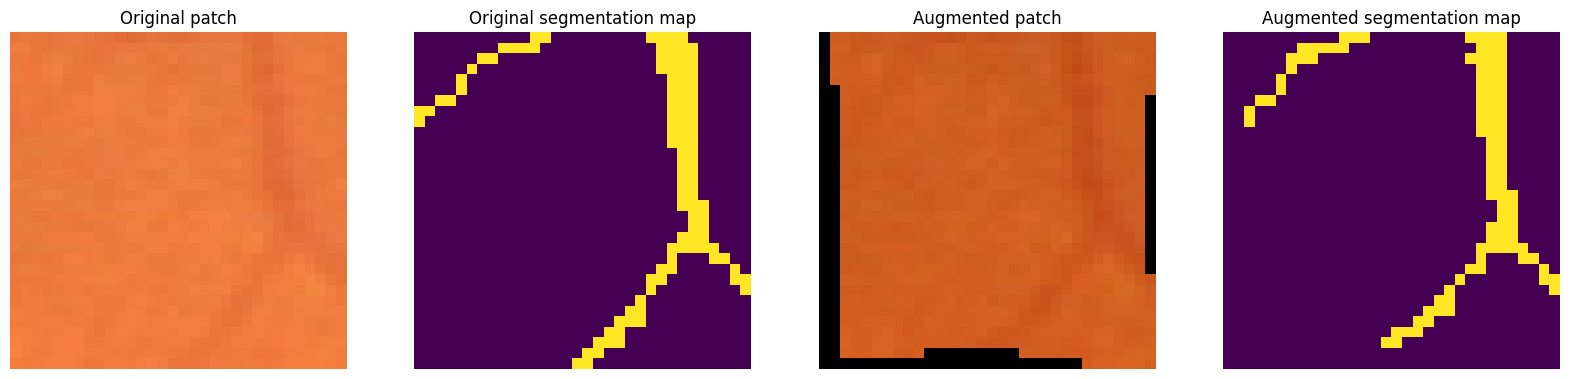

In [44]:
# Plotting an example of an augmented patch
patches_bspline, patches_seg_bspline = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7, augment=True, brightness=True, bspline=True)
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(patches[0])
ax[1].imshow(patches_segmentations[0])
ax[2].imshow(patches_bspline[0])
ax[3].imshow(patches_seg_bspline[0])

ax[0].set_title("Original patch")
ax[1].set_title("Original segmentation map")
ax[2].set_title("Augmented patch")
ax[3].set_title("Augmented segmentation map")
[axis.axis("off") for axis in ax];

In [47]:
# Train the model with data augmentation
model_bspline = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile the model
model_bspline.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model_bspline.fit(datagenerator(X_train, Y_train, patch_size, patches_per_im, batch_size, augment=True, brightness=True, bspline=True),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
                              callbacks=[early_stopping])

Epoch 1/25
50/50 [==============================] - 26s 474ms/step - loss: 0.6134 - accuracy: 0.7177 - val_loss: 0.4902 - val_accuracy: 0.9211
Epoch 2/25
50/50 [==============================] - 24s 486ms/step - loss: 0.3746 - accuracy: 0.9309 - val_loss: 0.3305 - val_accuracy: 0.9129
Epoch 3/25
50/50 [==============================] - 26s 515ms/step - loss: 0.2733 - accuracy: 0.9445 - val_loss: 0.3514 - val_accuracy: 0.9176
Epoch 4/25
50/50 [==============================] - 31s 619ms/step - loss: 0.2225 - accuracy: 0.9489 - val_loss: 0.2790 - val_accuracy: 0.9212
Epoch 5/25
50/50 [==============================] - 34s 681ms/step - loss: 0.1758 - accuracy: 0.9553 - val_loss: 0.2730 - val_accuracy: 0.9212
Epoch 6/25
50/50 [==============================] - 33s 661ms/step - loss: 0.1487 - accuracy: 0.9596 - val_loss: 0.2579 - val_accuracy: 0.9212
Epoch 7/25
50/50 [==============================] - 33s 660ms/step - loss: 0.1367 - accuracy: 0.9598 - val_loss: 0.2945 - val_accuracy: 0.9216

In [49]:
score_bspline = model_bspline.evaluate(val_images, val_segmentations, verbose=1)

print('Test loss baseline model:', score_baseline[0])
print('Test loss augmented model:', score_bspline[0])

print('Test accuracy baseline model:', score_baseline[1])
print('Test accuracy augmented model:', score_bspline[1])

1/1 [==============================] - 3s 3s/step - loss: 0.1941 - accuracy: 0.9300
Test loss baseline model: 0.3285822868347168
Test loss augmented model: 0.1941281259059906
Test accuracy baseline model: 0.8707030415534973
Test accuracy augmented model: 0.929955780506134


1/1 [==============================] - 1s 762ms/step


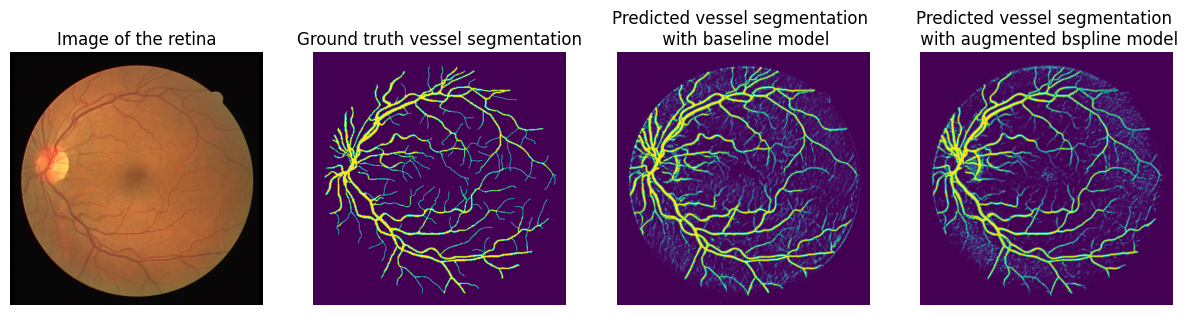

In [50]:
# predict test samples
test_prediction_bspline = model_bspline.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(15, 10))

plt.subplot(1, 4, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 4, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 4, 3)
plt.title("Predicted vessel segmentation \n with baseline model")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.subplot(1, 4, 4)
plt.title("Predicted vessel segmentation \n with augmented bspline model")
plt.axis('off')
plt.imshow(test_prediction_bspline[0, :, :, 0])

plt.show()

Again, we can see that the data augmentation has a positive effect on the model performance compared to the baseline. When comparing the two data augmentation methods, the one with only brightness fluctuations receives a higher accuracy on the testing set. This is the result after just 25 training epochs.